# CutMix 또는 Mixup 비교하기
최신 기법(CutMix, Mixup)을 적용해 모델을 훈련시키기  
두 방법 중 하나를 적용하고 모델 학습

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import tensorflow_datasets as tfds

GPU 환경 확인하기

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

이전에 사용했던 stanford_dogs 데이터셋을 이용  
total 20,580 이미지 train 12,000 test 8,580으로 구성

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split = ['train', 'test'],
    as_supervised = True,
    shuffle_files = True,
    with_info = True,
)

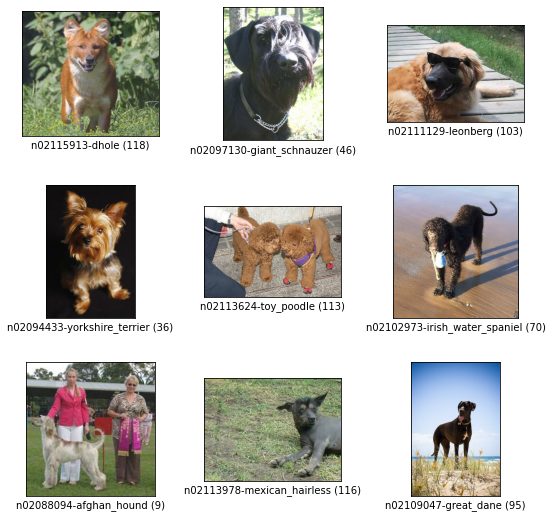

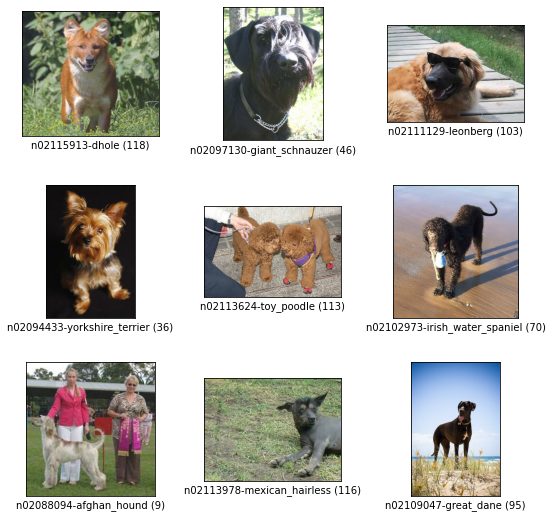

In [4]:
tfds.show_examples(ds_train, ds_info)

이미지 사이즈 조정 밑 픽셀 값 정규화, label의 one-hot vector화 함수

In [5]:
def normalize_and_resize_img(image, label):
    # Normalize img : uint8 -> float32
    image = tf.image.resize(image, [224, 224])    # 앞 노드와 같은 데이터라서 같은 사이즈 지정
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def basic_aug(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [7]:
num_classes = ds_info.features["label"].num_classes

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [8]:
def preprocessing(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,  
        num_parallel_calls=2
    )
    
    ds = ds.batch(batch_size)
    if not is_test:               # is_test = False
        ds = ds.map(
            onehot
        )
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds        

In [9]:
ds_train = preprocessing(ds_train)
ds_test = preprocessing(ds_test, is_test=True)

## Mixup Augmentation
두 개의 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식  
두 이미지 쌍을 섞는 비율은 일정한 범위 내에서 랜덤하게 정하고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞음
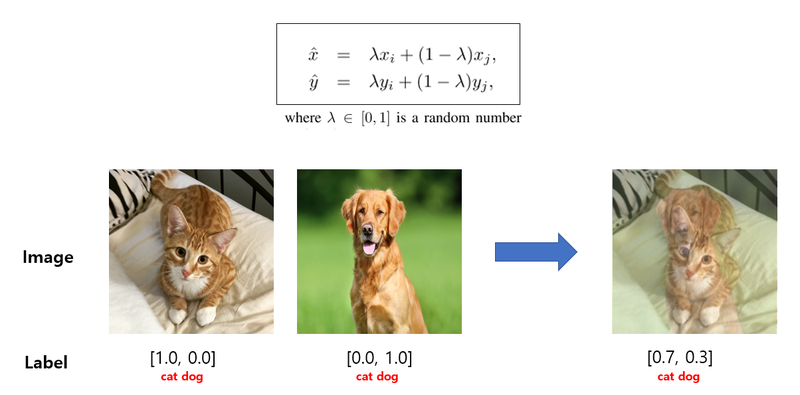

한 쌍의 이미지를 골라 섞어보기

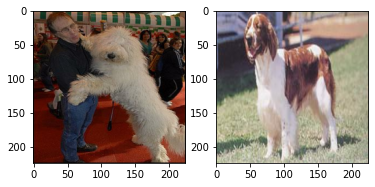

In [10]:
for i, (image, label) in enumerate(ds_train.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break
        
plt.subplot(1,2,1)
plt.imshow(image_a)
plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

Mixup 함수

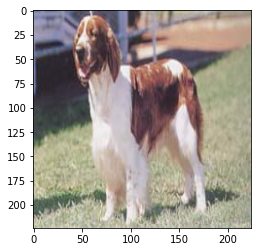

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.99549186 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00450814
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0. 

In [11]:
def mixup_img(image_a, image_b, label_a, labe_b):
    ratio = tf.random.uniform([], 0, 1)
    
    mixed_image = (1-ratio) * image_a + ratio * image_b
    mixed_label = (1-ratio) * label_a + ratio * label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_img(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

배치 단위의 mixup() 함수

In [12]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_img(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)
        
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## CutMix Augmentation
두 개의 이미지 데이터 a, b가 있을 경우  
b의 이미지를 일부 잘라 a에 붙여넣는다고 생각
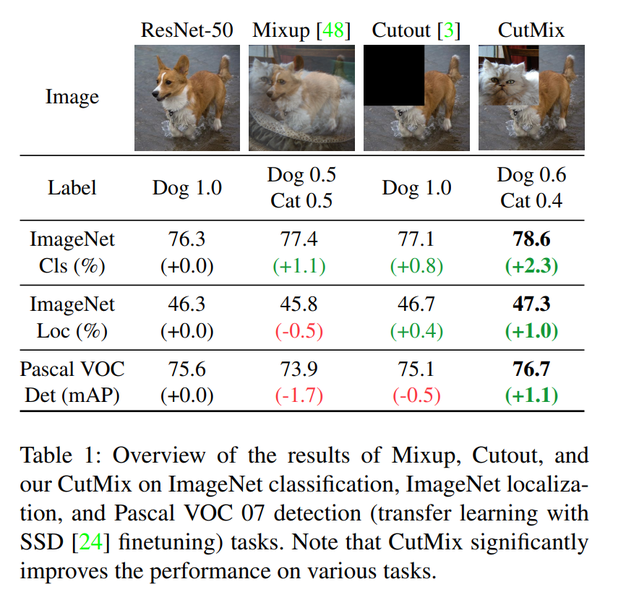
CutMix는 이미지를 섞는 부분과 섞은 이미지에 맞춰 라벨을 섞는 부분을 포함

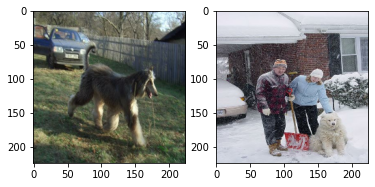

In [13]:
for i, (image, label) in enumerate(ds_train.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break
        
plt.subplot(1,2,1)
plt.imshow(image_a)
plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

좌측 이미지에 삽입될 영역의 바운딩 박스 위치를 경정하는 함수  

In [14]:
def get_clip_box(image_a, image_b):
    # img shape = (H, W, C)
    image_size_x = image_a.shape[1]  # W
    image_size_y = image_a.shape[0]  # H
    
    # center box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)
    
    # W, H box
    width = tf.cast(image_size_x * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    
    # minmax bounding box
    x_min = tf.math.maximum(0, x - width//2)
    y_min = tf.math.maximum(0, y - height//2)
    x_max = tf.math.minimum(image_size_x, x + width//2)
    y_max = tf.math.minimum(image_size_y, y + width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(36, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(109, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


바탕 이미지가 되는 좌측 이미지(a)의 바운딩 박스 외부 영역을  
삽입 이미지가 되는 우측 이미지(b)의 바운딩 박스 내부 영역을 가져와서 합치는 함수

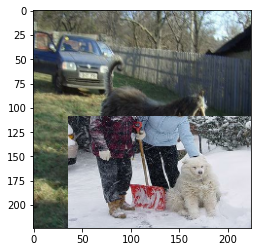

In [15]:
def mix_img(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    middle_left = image_a[y_min:y_max, 0:x_min, :]
    middle_center = image_b[y_min:y_max, x_min:x_max, :]
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :]
    middle = tf.concat([middle_left, middle_center, middle_right], axis=1)
    
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom], axis=0)
    
    return mixed_img

mixed_img = mix_img(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

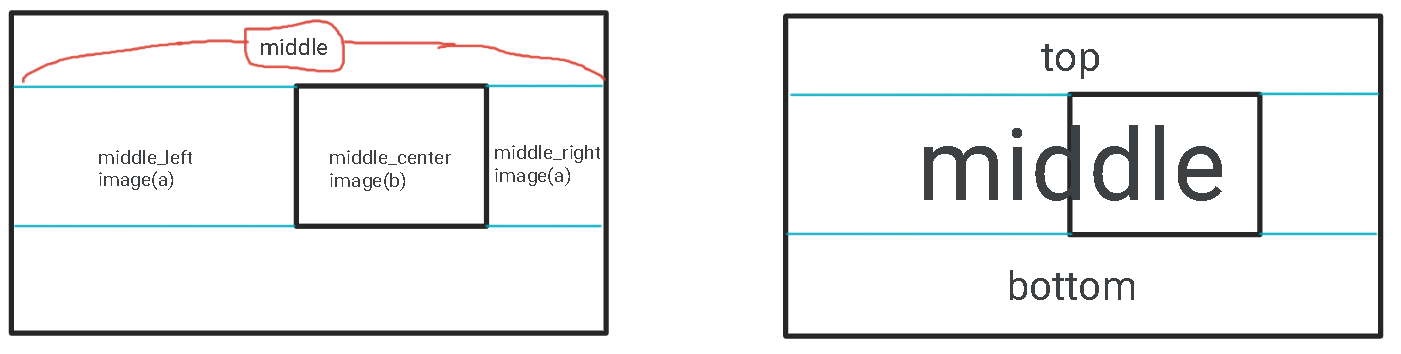

CutMix용 라벨 섞기  
면적에 비례하여 라벨을 섞는다  

In [16]:
def mix_label(label_a, label_b, x_min, y_min, x_max, y_max, num_calsses = 120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = tf.cast(mixed_area / total_area, tf.float32)
    
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    
    return mixed_label

mixed_label = mix_label(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.5691167, 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

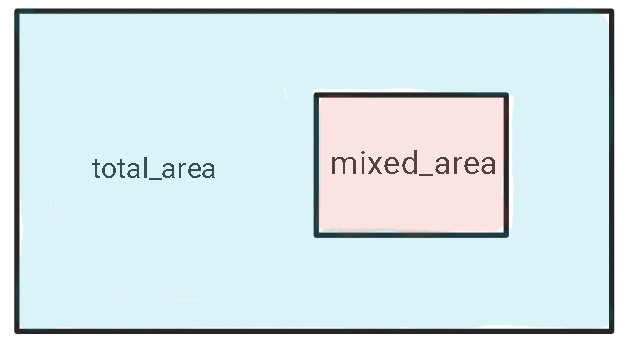

위 함수들을 이용하여 cutmix 함수 구현

In [17]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_img(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_label(image_a, image_b, x_min, y_min, x_max, y_max))
        
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

위에서 구현한 사이즈 조정, 정규화, 기본 augmentation, mixup, cutmix 함수를 한곳에 모으기

In [18]:
def augmentation(ds, is_test=False, batch_size=16, with_aug = False, with_cutmix = False, with_mixup = False):  
    # is_test -> False == train_data / True == test_data
    # with_aug  -> 기본 aug적용 유무
    # with_cutmix -> cutmix aug적용 유무
    # with_mixup -> mixup aug적용 유무
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )

    if not is_test and with_aug:    # train_data + basic_aug 인 경우
        ds = ds.map(
            basic_aug
        )
    
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix: # train_data + cutmix_aug 인 경우
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    if not is_test and with_mixup:  # train_data + mixup_aug 인 경우
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    if not is_test:                 # train_data 인 경우  
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split = ['train', 'test'],
    as_supervised = True,
    shuffle_files = True,
    with_info = True,
)

뭐가 문제지,,,?!?!???!?!?  
mixup만 구현했을때는 잘 되었다가  
cutmix 를 추가하니 꼬여버리는군요요요요요  
데이터 형태가 맞지 않는다는 오류인거같은데,,,,,  
제 머리도 어긋난거같아요  
사ㅏㅏㅏㄹ  
려ㅕㅕ  
줘ㅓㅓ  

In [20]:
plain_ds_train = augmentation(ds_train)
basic_aug_ds_train = augmentation(ds_train, with_aug = True)
mixup_ds_train = augmentation(ds_train, with_mixup = True)
cutmix_ds_train = augmentation(ds_train, with_cutmix = True)

ds_test = augmentation(ds_test, is_test=True)

TypeError: in user code:

    /tmp/ipykernel_4262/447738930.py:11 mixup  *
        mixed_img, mixed_label = mixup_img(image_a, image_b, label_a, label_b)
    /tmp/ipykernel_4262/3581564435.py:5 mixup_img  *
        mixed_label = (1-ratio) * label_a + ratio * label_b
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1383 binary_op_wrapper
        raise e
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1367 binary_op_wrapper
        return func(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1710 _mul_dispatch
        return multiply(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:530 multiply
        return gen_math_ops.mul(x, y, name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py:6245 mul
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:555 _apply_op_helper
        raise TypeError(

    TypeError: Input 'y' of 'Mul' Op has type int64 that does not match type float32 of argument 'x'.


으,,, 모르겠어요,,,,,

imagenet으로 학습된 keras의 ResNet50 모델 불러와서 학습  
augmentation이 적용된 데이터와 적용되지 않은 데이터 각각 다른 모델에서 학습

In [21]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [22]:
basic_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [23]:
cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [24]:
mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])